In [ ]:
# Average Energy Usage on distillation of all the models

# ==========================
# 0) CONFIG (EDIT THIS ONLY)
# ==========================
# Core
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Optional (only if you really want seaborn styling helpers)
# import seaborn as sns



CFG = {
    # Root folder containing FEATURE/RESPONSE/RELATION
    "ROOT": Path("."),  # <- set to your repo root if needed

    # KD types to include (must match folder names)
    "KD_TYPES": ["FEATURE", "RESPONSE", "RELATION", "TRADITIONAL STUDENT"],

    # 5 runs per type
    "MODEL_DIRS": [f"MODEL {i}" for i in range(1, 6)],

    # telemetry filename
    "TELEMETRY_FILE": "telemetry.jsonl",

    # Which GPUs to include: None = all, or e.g. [0,1,2,3]
    "GPU_INDICES": None,

    # Resampling grid (seconds). 1.0 = 1 Hz paper-friendly
    "DT_S": 1.0,

    # Time range behavior for averaging:
    # "min" = 0..min(end) across runs (reviewer-safe)
    # "max" = 0..max(end) with NaNs ignored
    "COMMON_RANGE": "min",

    # Plot choices
    "Y_UNIT": "kWh",   # "J" or "kWh"
    "SHOW_STD_BAND": True,
    "DOT_EVERY_S": 100,  # put dots every N seconds (paper readability)
    "LINEWIDTH": 2.0,
    "MARKERSIZE": 4.5,
    "ALPHA_BAND": 0.15,

    # Figure / export
    "FIGSIZE": (6.5, 4.0),  # tweak for 1-col vs 2-col
    "DPI": 300,
    "TITLE": None,  # e.g. "Distillation Energy Over Time" or None
    "XLABEL": "Elapsed time (s)",
    "YLABEL": None,  # auto if None
    "LEGEND_LOC": "best",

    # Save
    "SAVE": True,
    "OUTDIR": Path("figures"),
    "BASENAME": "kd_energy_vs_time",  # outputs .pdf and .svg
}

CFG["KD_COLORS"] = {
    "FEATURE": "#4e79a7",   # blue
    "RESPONSE": "#59a14f",  # green
    "RELATION": "#edc949",  # yellow
    "TRADITIONAL STUDENT": "#000000",
}

CFG["KD_MARKERS"] = {
    "FEATURE": "s",
    "RESPONSE": "s",
    "RELATION": "s",
    "TRADITIONAL STUDENT": "s",
}



In [5]:
# ==========================
# 1) LOAD + TRANSFORM (JSONL -> time series)
# ==========================
import json
import pandas as pd
import numpy as np
from datetime import datetime

def _parse_ts(ts: str) -> pd.Timestamp:
    # Handles ISO timestamps with timezone offsets
    return pd.to_datetime(ts, utc=True)

def load_telemetry_series(path: Path, gpu_indices=None) -> pd.DataFrame:
    """
    Returns df with columns:
      t_sec (float), E_run_J (float), E_run_kWh (float)
    where E_run_* starts at 0 for the first sample.
    """
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)

            ts = _parse_ts(obj["timestamp"])
            gpus = obj.get("gpus", [])

            # sum energy_mJ across selected GPUs
            total_mJ = 0.0
            for g in gpus:
                idx = g.get("gpu_index")
                if (gpu_indices is None) or (idx in gpu_indices):
                    # energy_mJ is cumulative counter per GPU
                    total_mJ += float(g.get("energy_mJ", 0.0))

            rows.append({"timestamp": ts, "E_total_mJ": total_mJ})

    if not rows:
        raise ValueError(f"No telemetry rows found in {path}")

    df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)

    # elapsed seconds from start
    t0 = df["timestamp"].iloc[0]
    df["t_sec"] = (df["timestamp"] - t0).dt.total_seconds()

    # run energy is delta from first sample (so it starts at 0)
    E0 = df["E_total_mJ"].iloc[0]
    df["E_run_mJ"] = df["E_total_mJ"] - E0

    # convert units
    df["E_run_J"] = df["E_run_mJ"] / 1000.0
    df["E_run_kWh"] = df["E_run_J"] / 3_600_000.0

    # quick sanity: monotonic-ish (allow tiny jitter)
    # If you ever see negative drops, we can add reset-handling logic.
    return df[["t_sec", "E_run_J", "E_run_kWh"]]


In [ ]:
# ==========================
# 2) BUILD RUNS (per KD type)
# ==========================
def get_run_paths(cfg) -> dict:
    root = cfg["ROOT"]
    out = {}

    for kd in cfg["KD_TYPES"]:
        if kd == "TRADITIONAL STUDENT":
            # Prefer exactly this file if it exists
            p = root / kd / cfg["TELEMETRY_FILE"]
            if p.exists():
                out[kd] = [p]
                continue

            # # Fallback: if telemetry.jsonl is nested for some reason, find it
            # matches = sorted((root / kd).rglob(cfg["TELEMETRY_FILE"]))
            # if not matches:
            #     raise FileNotFoundError(
            #         f"Could not find {cfg['TELEMETRY_FILE']} under {root/kd}"
            #     )
            # out[kd] = [matches[0]]  # pick the first match
        else:
            paths = []
            for m in cfg["MODEL_DIRS"]:
                paths.append(root / kd / m / cfg["TELEMETRY_FILE"])
            out[kd] = paths

    return out


run_paths = get_run_paths(CFG)
run_paths


{'FEATURE': [PosixPath('FEATURE/MODEL 1/telemetry.jsonl'),
  PosixPath('FEATURE/MODEL 2/telemetry.jsonl'),
  PosixPath('FEATURE/MODEL 3/telemetry.jsonl'),
  PosixPath('FEATURE/MODEL 4/telemetry.jsonl'),
  PosixPath('FEATURE/MODEL 5/telemetry.jsonl')],
 'RESPONSE': [PosixPath('RESPONSE/MODEL 1/telemetry.jsonl'),
  PosixPath('RESPONSE/MODEL 2/telemetry.jsonl'),
  PosixPath('RESPONSE/MODEL 3/telemetry.jsonl'),
  PosixPath('RESPONSE/MODEL 4/telemetry.jsonl'),
  PosixPath('RESPONSE/MODEL 5/telemetry.jsonl')],
 'RELATION': [PosixPath('RELATION/MODEL 1/telemetry.jsonl'),
  PosixPath('RELATION/MODEL 2/telemetry.jsonl'),
  PosixPath('RELATION/MODEL 3/telemetry.jsonl'),
  PosixPath('RELATION/MODEL 4/telemetry.jsonl'),
  PosixPath('RELATION/MODEL 5/telemetry.jsonl')],
 'TRADITIONAL STUDENT': [PosixPath('TRADITIONAL STUDENT/telemetry.jsonl')]}

In [11]:
# ==========================
# 3) RESAMPLE + AGGREGATE (mean/std over 5 runs)
# ==========================
def resample_to_grid(df: pd.DataFrame, grid: np.ndarray, ycol: str) -> np.ndarray:
    # Interpolate onto grid
    x = df["t_sec"].to_numpy()
    y = df[ycol].to_numpy()
    # np.interp requires ascending x
    return np.interp(grid, x, y)

def aggregate_kd_type(paths, cfg) -> pd.DataFrame:
    ycol = "E_run_kWh" if cfg["Y_UNIT"].lower() == "kwh" else "E_run_J"

    series = []
    ends = []

    for p in paths:
        if not p.exists():
            raise FileNotFoundError(f"Missing telemetry file: {p}")
        df = load_telemetry_series(p, gpu_indices=cfg["GPU_INDICES"])
        series.append(df)
        ends.append(df["t_sec"].iloc[-1])

    if cfg["COMMON_RANGE"] == "min":
        t_end = float(np.min(ends))
    else:
        t_end = float(np.max(ends))

    dt = float(cfg["DT_S"])
    grid = np.arange(0.0, t_end + 1e-9, dt)

    Y = []
    for df in series:
        # if COMMON_RANGE == "min", everyone covers grid fully
        # if "max", some runs may be shorter; we handle by clipping + NaN padding
        if cfg["COMMON_RANGE"] == "max" and df["t_sec"].iloc[-1] < grid[-1]:
            # interpolate up to its end, then pad NaNs
            g2 = grid[grid <= df["t_sec"].iloc[-1]]
            y2 = resample_to_grid(df, g2, ycol)
            y_full = np.full_like(grid, np.nan, dtype=float)
            y_full[: len(g2)] = y2
            Y.append(y_full)
        else:
            Y.append(resample_to_grid(df, grid, ycol))

    Y = np.vstack(Y)  # shape: (num_runs, T)

    mean = np.nanmean(Y, axis=0)
    std  = np.nanstd(Y, axis=0)

    return pd.DataFrame({"t_sec": grid, "mean": mean, "std": std})

agg = {kd: aggregate_kd_type(paths, CFG) for kd, paths in run_paths.items()}
{k: v.head() for k, v in agg.items()}


{'FEATURE':    t_sec      mean       std
 0    0.0  0.000000  0.000000
 1    1.0  0.065828  0.002724
 2    2.0  0.133109  0.002434
 3    3.0  0.203016  0.002916
 4    4.0  0.272415  0.002501,
 'RESPONSE':    t_sec      mean       std
 0    0.0  0.000000  0.000000
 1    1.0  0.070853  0.002432
 2    2.0  0.141248  0.002722
 3    3.0  0.212111  0.001808
 4    4.0  0.284260  0.001335,
 'RELATION':    t_sec      mean       std
 0    0.0  0.000000  0.000000
 1    1.0  0.070940  0.003082
 2    2.0  0.143285  0.005358
 3    3.0  0.216196  0.005963
 4    4.0  0.289056  0.008403,
 'TRADITIONAL STUDENT':    t_sec      mean  std
 0    0.0  0.000000  0.0
 1    1.0  0.016511  0.0
 2    2.0  0.033220  0.0
 3    3.0  0.049930  0.0
 4    4.0  0.066658  0.0}

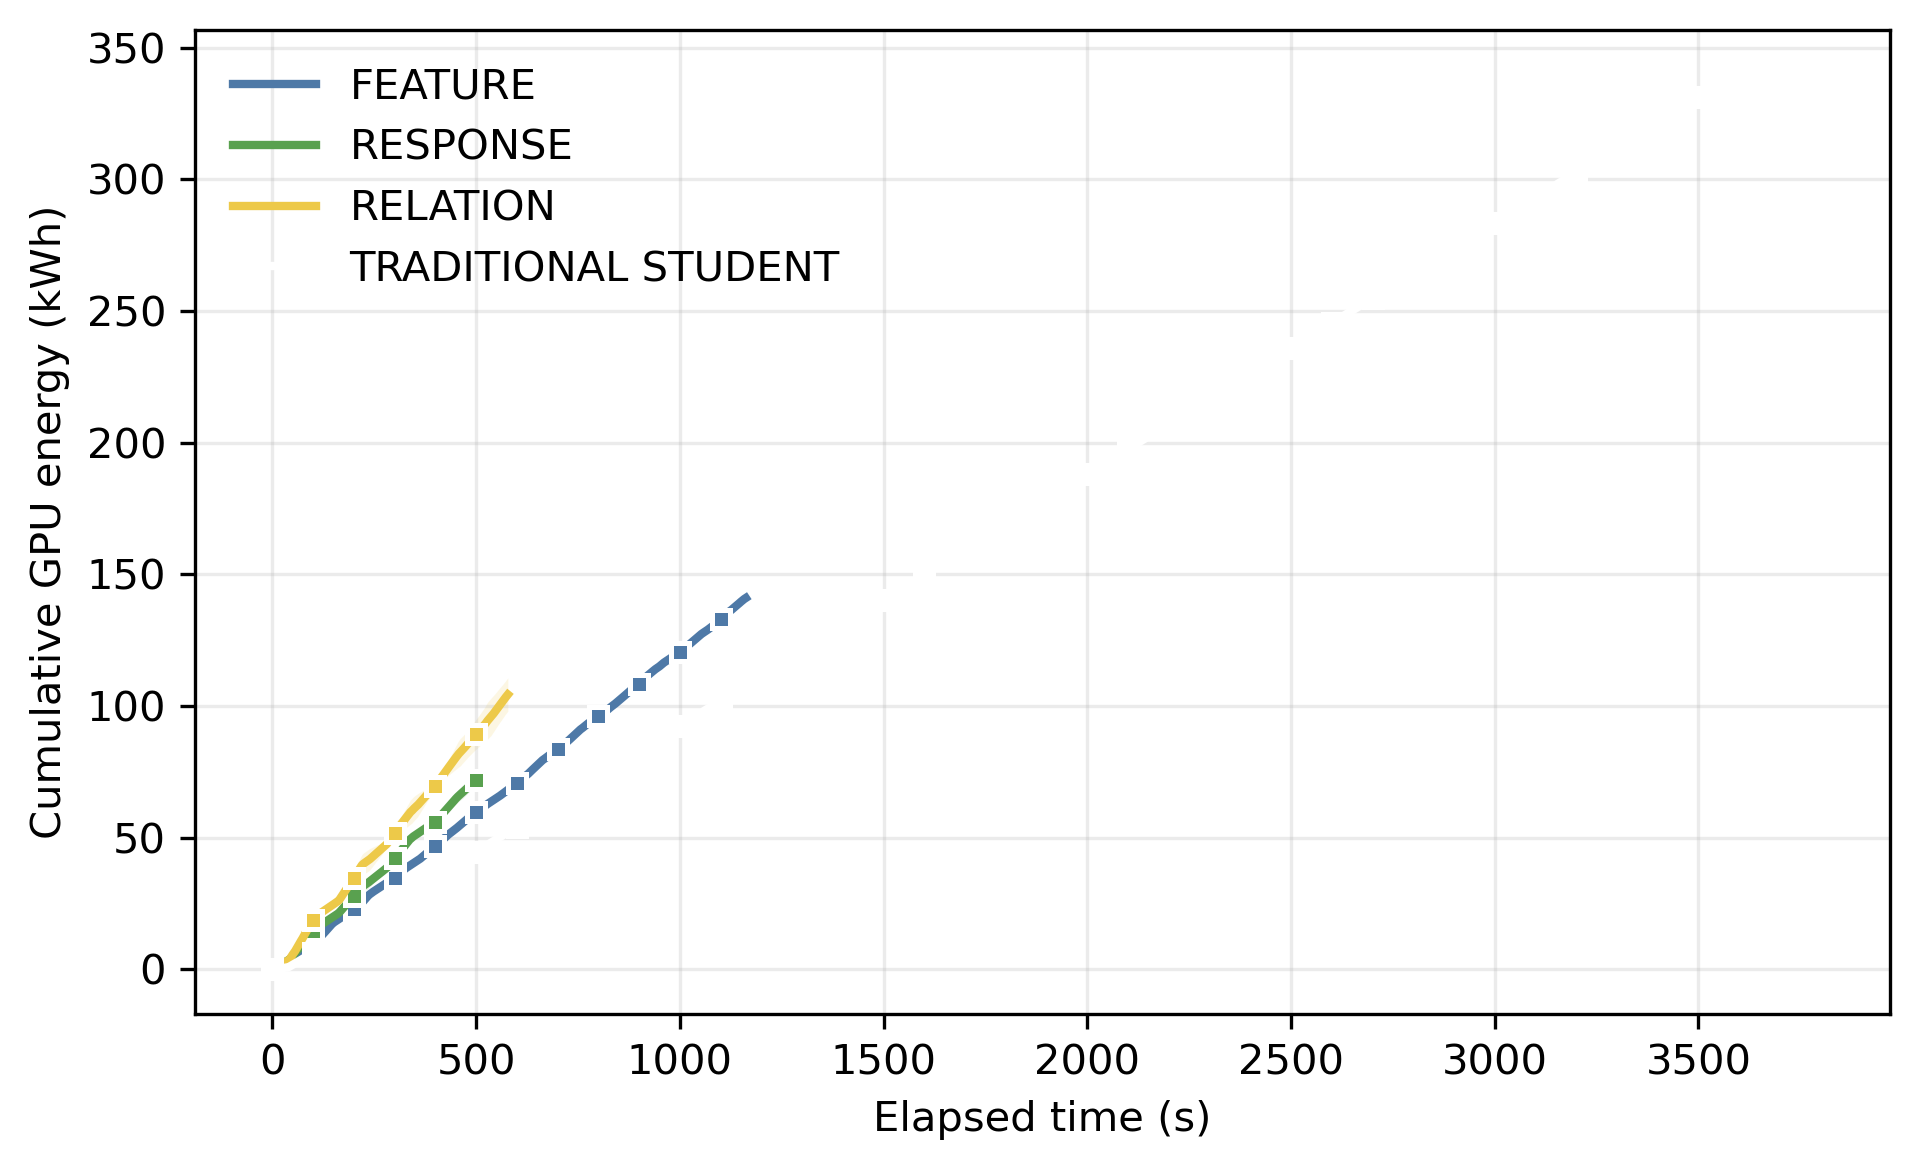

In [12]:
# ==========================
# 4) PLOT (paper-ready, easy knobs)
# ==========================
import matplotlib.pyplot as plt

def plot_energy_curves(agg_dict, cfg):
    fig, ax = plt.subplots(figsize=cfg["FIGSIZE"], dpi=cfg["DPI"])

    # auto labels
    if cfg["YLABEL"] is None:
        cfg_ylabel = (
            "Cumulative GPU energy (kWh)"
            if cfg["Y_UNIT"].lower() == "kwh"
            else "Cumulative GPU energy (J)"
        )
    else:
        cfg_ylabel = cfg["YLABEL"]

    for kd, df in agg_dict.items():
        x = df["t_sec"].to_numpy()
        y = df["mean"].to_numpy()
        s = df["std"].to_numpy()

        color  = cfg["KD_COLORS"].get(kd, "black")
        marker = cfg["KD_MARKERS"].get(kd, "o")

        # main line
        ax.plot(
            x, y,
            linewidth=cfg["LINEWIDTH"],
            color=color,
            label=kd,
        )

        # dots every N seconds
        dot_every = max(1, int(round(cfg["DOT_EVERY_S"] / cfg["DT_S"])))
        ax.plot(
            x[::dot_every],
            y[::dot_every],
            linestyle="None",
            marker=marker,
            markersize=cfg["MARKERSIZE"],
            color=color,
            markeredgecolor="white",
            markeredgewidth=1.2,
        )

        # std band
        if cfg["SHOW_STD_BAND"]:
            ax.fill_between(
                x,
                y - s,
                y + s,
                color=color,
                alpha=cfg["ALPHA_BAND"],
                linewidth=0,
            )

    ax.set_xlabel(cfg["XLABEL"])
    ax.set_ylabel(cfg_ylabel)
    if cfg["TITLE"]:
        ax.set_title(cfg["TITLE"])

    ax.legend(loc=cfg["LEGEND_LOC"], frameon=False)
    ax.grid(True, alpha=0.25)

    fig.tight_layout()

    if cfg["SAVE"]:
        cfg["OUTDIR"].mkdir(parents=True, exist_ok=True)
        fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.pdf", bbox_inches="tight")
        fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.svg", bbox_inches="tight")

    return fig, ax


fig, ax = plot_energy_curves(agg, CFG)

# ---- Global font / style (portable, Palatino if present) ----
matplotlib.rcdefaults()
matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino Linotype", "Liberation Sans", "DejaVu Sans", "Arial"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
})

plt.savefig('Average Energy Usage in Distillation.pdf', bbox_inches='tight', dpi=300)
plt.show()
